# K-Means Clustering

<font size = 4px>Defination:</font> <font size = 3.5px>K-Means Clustering is a machine learning algorithm used to group similar data points together into k clusters and infer about their underlying pattern.</font>

### <u>Pseudo Code (from scratch)<u>:

`1. Initialize centroids:`  <br>
`    Randomly select k unique data points from data set as initial centroids` <br> 
`                                                                             ` <br>
`2. Repeat until convergence:` <br>
`    a. Assign each data point to the nearest centroid` <br>
`    b. Recompute the centroids as the mean of the data points assigned to each centroid` <br>
`    c. Check for convergence, If the centroids do not change more than a specified tolerance, break the loop` <br>
`                                                                                                            ` <br>
`3. Return the final centroids and clusters`<br>

## 1. Mathematical Understanding of the model:

<font size=3.5px>Say, we have a given data set {$x_1, x_2, x_3, ..., x_n$} and we want to group those data sets into k clusters. So, first we'll initialize k unique centers $\mu_1, \mu_2, \mu_3, \mu_4, ..., \mu_k \in \mathbb{R}^d$ from the data set randomly where d is the dimension of the given dataset. </font>

<font size=3.5px>Now, second step is to find the Euclidean distance between each point and centroid. Compare the distances and assign each point to the nearest centroid.<br><center>$Euclidean \space distance, d = \lVert x - \mu \lVert$</center><br><center>$c^{(1)} = {arg min}_\beta {\lVert x^{(i)} - \mu_\beta \lVert}^2, \quad \beta \in \{1, 2, ..., k\}$</center><br>This way, n number of points are mapped to k centroids making k number of clusters (c).<br><br>Then, it's time to recompute the centroids. this is done by taking mean of all the data points contained in a cluster. For 1st iteration, mean value:<br><center>$$\mu^1_\beta = \frac{\sum_{i=1}^{n}x_i \mathbb{1}(z^1_i = \beta)}{\sum_{i=1}^{n} \mathbb{1}(z^1_i = \beta)},\quad \beta \in \{1, 2, ..., k\}$$</center></font>

<font size=3.5px>Again, each point is reassigned to it's nearest recomputed centroid. So, the clusters of 2nd iteration are defined as:<br><center>$c^{(2)}_i = {arg min}_\beta{\lVert x^{(1)}_i - \mu_\beta^{(1)} \lVert}^2$</center><br>This process goes on repetation 
   until the algorithm converges.</font>

## Our Model From Scratch

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output
from scipy.optimize import linear_sum_assignment

In [2]:
# This class will process the given file to execute features and target into X and y numpy array
class DataPreprocessor:
    def __init__(self, filepath):
        self.given_data = pd.read_csv(filepath)
        self.X, self.y = self.data_cleaning()

    def data_cleaning(self): # Clean the data i.e. features and target into X and y numpy array
        features = [col for col in self.given_data.columns if 'Feature' in col]
        self.given_data = self.given_data.dropna()
        data = self.given_data[features].copy()
        data = (data - data.min()) / (data.max() - data.min()) * 9 + 1  # Scale data from 1 to 10
        target = self.given_data['Target'].copy()
        X = np.array(data)
        y = np.array(target)
        return X, y

In [3]:
# This class perform,s kmeans clustering
class KMeansClustering:
    def __init__(self, X, y, k_value=2, max_iter=100):
        self.y = y
        self.k_value = k_value
        self.max_iter = max_iter
        self.centroids = None
        self.iterations = 0  # Track iterations for plotting
        
    def train(self, X):
        random_index = random.sample(range(0, X.shape[0]), self.k_value) # Getting a random index on X column
        self.centroids = X[random_index] # initializing centroids on that random indexes
        for i in range(self.max_iter):
            # Assign clusters
            self.cluster_group = self.assign_clusters(X)
            old_centroids = self.centroids.copy()
            # Move centroids
            self.centroids = self.move_centroids(X)
            self.iterations += 1
            # Check if finish/ converges
            if np.all(old_centroids == self.centroids):
                break
        self.cluster_group

    def get_labels(self):
        return self.cluster_group
    
    def assign_clusters(self, X): # Assign the cluster in each iteration over epochs
        cluster_group = []
        for row in X:
            distances = [np.sqrt(np.dot(row - centroid, row - centroid)) for centroid in self.centroids] # Euclidean distance
            min_distance = min(distances) # min distance
            index_pos = distances.index(min_distance) #Imndex position of min distance
            cluster_group.append(index_pos)
        return np.array(cluster_group)

    def move_centroids(self, X): # move centroids by calculating the mean value
        cluster_group = self.assign_clusters(X) # new cluster
        new_centroids = []
        for cluster in range(self.k_value):
            new_centroids.append(X[cluster_group == cluster].mean(axis=0)) # append them
        return np.array(new_centroids)
    
    def predict(self, X): # predict the cluster_group or y value
        return self.assign_clusters(X)

    
    def data_plotter(self, X, labels): # plot given data
        pca = PCA(n_components=2)
        data_2d = pca.fit_transform(X)  # to fit 3D into 2D
        centroids_2d = pca.transform(self.centroids)
        clear_output(wait=True)
        plt.title(f'Iteration {self.iterations}')
        plt.scatter(x=data_2d[:, 0], y=data_2d[:, 1], c=labels, alpha=0.5)
        plt.scatter(x=centroids_2d[:, 0], y=centroids_2d[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.legend()
        plt.show()

In [4]:
from sklearn.metrics import silhouette_score
from scipy.optimize import linear_sum_assignment
class ModelEvaluator: # evaluate model using hungarian method (normal method is not applicable as it's a random algorithm)
    @staticmethod
    def cluster_accuracy(y_true, y_pred):
        y_true = y_true.astype(np.int64) # Typecasting
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max()) + 1 # Getting D to make D*D matrix
        w = np.zeros((D, D), dtype=np.int64)

        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        row, column = linear_sum_assignment(w.max() - w)

        return sum([w[i, j] for i, j in zip(row, column)]) * 1.0 / y_pred.size

## 2. (a) Training the scratch model

### [dataset 1]

In [5]:
data_preprocessor1 = DataPreprocessor('data1_train.csv')
X_train1, y_train1 = data_preprocessor1.X, data_preprocessor1.y

In [6]:
kmeans_model1 = KMeansClustering(X_train1, y_train1, k_value=3)

In [7]:
kmeans_model1.train(X_train1)

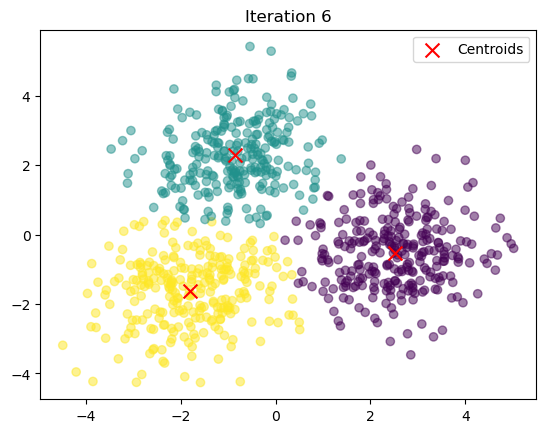

In [8]:
labels1 = kmeans_model1.get_labels()
kmeans_model1.data_plotter(X_train1, labels1)

In [9]:
score = ModelEvaluator.cluster_accuracy(y_train1, labels1)
print(f'Accuracy: {score*100}%')

Accuracy: 97.0%


### [Dataset 2]

In [10]:
data_preprocessor2 = DataPreprocessor('data2_train.csv')
X_train2, y_train2 = data_preprocessor2.X, data_preprocessor2.y
kmeans_model2 = KMeansClustering(X_train2, y_train2, 2)
kmeans_model2.train(X_train2)

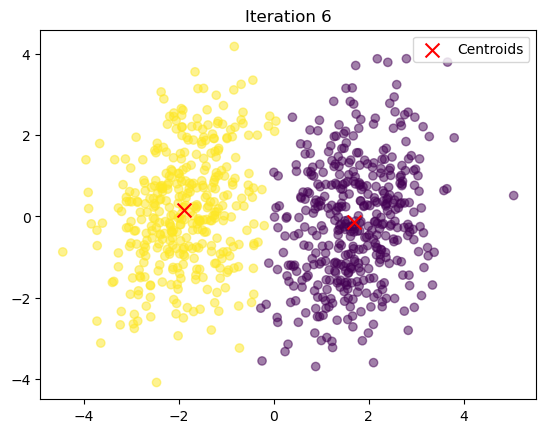

In [11]:
labels2 = kmeans_model2.get_labels()
kmeans_model2.data_plotter(X_train2, labels2)

In [12]:
score = ModelEvaluator.cluster_accuracy(y_train2, labels2)
print(f'Accuracy: {score*100}%')

Accuracy: 99.0%


## 2. (b) Testing the scratch model 

### [Dataset 1]

In [13]:
data_preprocessor_test1 = DataPreprocessor('data1_test.csv')
X_test1, y_test1 = data_preprocessor_test1.X, data_preprocessor_test1.y

In [14]:
# Predict on the test set
y_pred_test1 = kmeans_model1.predict(X_test1)
print("Predictions on test set:", np.bincount(y_pred_test1))

Predictions on test set: [60 68 72]


In [15]:
score = ModelEvaluator.cluster_accuracy(y_test1, y_pred_test1)
print(f'Accuracy: {score*100}%')

Accuracy: 97.5%


### [Dataset 2]

In [16]:
data_preprocessor_test2 = DataPreprocessor('data2_test.csv')
X_test2, y_test2 = data_preprocessor_test2.X, data_preprocessor_test2.y

In [17]:
# Predict on the test set
y_pred_test2 = kmeans_model2.predict(X_test2)
print("Predictions on test set:", np.bincount(y_pred_test2))

Predictions on test set: [ 94 106]


In [18]:
score = ModelEvaluator.cluster_accuracy(y_test2, y_pred_test2)
print(f'Accuracy: {score*100}%')

Accuracy: 93.5%


## 3. Hyperparameter Tuning

In [19]:
# hyperparameters are k value and maximum iterations (grid search)
from sklearn.metrics import silhouette_score

class HyperparameterTuning(KMeansClustering):
    def __init__(self, X, y, k_value=2, max_iter = 100):
        super().__init__(X, y, k_value, max_iter)
            
    def grid_search(self, X, y, param_grid):
        best_params = None
        best_score = -1

        # iterate over each value to check
        for k_value in param_grid['k_value']: 
            for max_iter in param_grid['max_iter']:
                self.k_value = k_value
                self.max_iter = max_iter
                self.kmeans = KMeansClustering(X, y, k_value=self.k_value, max_iter=self.max_iter) 
                self.train(X)
                y_pred = self.predict(X)
                labels = self.get_labels()

                score = self.evaluate(y, y_pred)


                if score > best_score: # fget the best score
                    best_score = score
                    best_params = {'k_value': k_value, 'max_iter': max_iter}
                    
        return best_params, best_score

    def evaluate(self, y, y_pred):
        accuracy = ModelEvaluator.cluster_accuracy(y, y_pred)
        return accuracy

In [20]:
# Define the hyperparameter grid
param_grid = {
    'k_value': [1, 2, 3, 4, 5, 6],
    'max_iter': [10, 50, 100, 500, 1000]
}

### On Dataset 1

In [21]:
# search for the best parameter and value
grid_search_model = HyperparameterTuning(X_train1, y_train1)
best_params1, best_score1 = grid_search_model.grid_search(X_train1, y_train1, param_grid)
print(f"Best Parameters: {best_params1}, Best Score: {best_score1*100}%")

Best Parameters: {'k_value': 3, 'max_iter': 100}, Best Score: 97.0%


In [22]:
# Initialize a model using the best value to compare accuracy
best_model1 = HyperparameterTuning(X_train1, y_train1, k_value=best_params1['k_value'], max_iter=best_params1['max_iter'])
best_model1.train(X_train1)

In [23]:
# best possible outcome
tuned_y_pred1 = best_model1.predict(X_test1)
print("Predictions on test set:", np.bincount(tuned_y_pred1))
score = ModelEvaluator.cluster_accuracy(y_test1, tuned_y_pred1)
print(f'Accuracy: {score*100}%')

Predictions on test set: [72 60 68]
Accuracy: 97.5%


### On Dataset 2

In [24]:
grid_search_model = HyperparameterTuning(X_train2, y_train2)
best_params2, best_score2 = grid_search_model.grid_search(X_train2, y_train2, param_grid)
print(f"Best Parameters: {best_params2}, Best Score: {best_score2*100}%")

Best Parameters: {'k_value': 2, 'max_iter': 100}, Best Score: 99.0%


In [25]:
best_model2 = HyperparameterTuning(X_train2, y_train2, k_value=best_params2['k_value'], max_iter=best_params2['max_iter'])
best_model2.train(X_train2)

In [26]:
tuned_y_pred2 = best_model2.predict(X_test2)
print("Predictions on test set:", np.bincount(tuned_y_pred2))
score = ModelEvaluator.cluster_accuracy(y_test2, tuned_y_pred2)
print(f'Accuracy: {score*100}%')

Predictions on test set: [ 94 106]
Accuracy: 93.5%


## 4. Comparision with Scikit-Learn

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class SkLearnKMeans:
    def __init__(self):
        self.model = KMeans(n_init = 10)
        
    def train(self, X_train):
        self.model.fit(X_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def accuracy_evaluator(self, X, y, labels):
        self.accuracy = ModelEvaluator.cluster_accuracy(y, labels)
        self.accuracy1 = silhouette_score(X, labels)
        print(f'Accuracy: {self.accuracy*100}%')
        print(f'Silhouette score: {self.accuracy1*100}%')

In [28]:
sklearn_model = SkLearnKMeans() # Initialize the model

### - On Dataset 1 (test & train)

In [29]:
sklearn_model.train(X_train1) # Training the model using train1 dataset

In [30]:
y_sk_pred1 = sklearn_model.predict(X_test1) # Getting the predicted y value

In [31]:
# Evaluate accuracy: SKlearn is using different k value which is making this accuracy test with given data/target worse
sklearn_model.accuracy_evaluator(X_test1, y_test1, y_sk_pred1) 

Accuracy: 57.49999999999999%
Silhouette score: 22.019369929633758%


### - On Dataset 2 (test & train)

In [32]:
# Same as previous but with train2 dataset
sklearn_model.train(X_train2)
y_sk_pred2 = sklearn_model.predict(X_test2)
sklearn_model.accuracy_evaluator(X_test2, y_test2, y_sk_pred2)

Accuracy: 41.0%
Silhouette score: 31.85043135585882%
